In [ ]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Input, Embedding, Dense, TimeDistributed
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



In [ ]:
df = pd.read_csv('/content/drive/My Drive/ML_Data/Womens Clothing E-Commerce Reviews.csv')

df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
df.isnull().sum()

df = df.dropna(axis=0)

df.isnull().sum()

Unnamed: 0                 0
Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

In [ ]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


In [ ]:
# define a dictionary of all possible contractions and their expanded forms
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
def clean_text(sentence):
  sentence = " ".join([contraction_mapping[val] if val in contraction_mapping else val for val in sentence.split()])
  sentence = sentence.lower()
  sentence = " ".join([contraction_mapping[val] if val in contraction_mapping else val for val in sentence.split()])
  sentenec = re.sub("’s\b", "", sentence)
  sentence = re.sub('[^a-zA-Z.,]', ' ', sentence)

  long_tokens = []

  for i in sentence.split():
    if(len(i) >= 2):
      long_tokens.append(i)

  return " ".join(long_tokens)

In [ ]:
text = np.array(df["Review Text"])

cleaned_text = np.array(df["Review Text"].apply(lambda x : clean_text(x)))

title = np.array(df["Title"])

udf = pd.DataFrame({"title": title, "text": text, "cleaned_text": cleaned_text})

udf.head()

,title,text,cleaned_text
0,Some major design flaws,I had such high hopes for this dress and reall...,had such high hopes for this dress and really ...
1,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...","love, love, love this jumpsuit. it is fun, fli..."
2,Flattering shirt,This shirt is very flattering to all due to th...,this shirt is very flattering to all due to th...
3,Not for the very petite,"I love tracy reese dresses, but this one is no...","love tracy reese dresses, but this one is not ..."
4,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,aded this in my basket at hte last mintue to s...


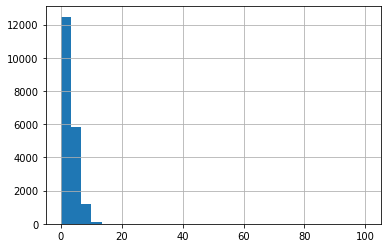

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

text_len = []
title_len = []

for i in cleaned_text:
  text_len.append(len(i.split()))

for i in title:
  title_len.append(len(i.split()))

title_stats = pd.DataFrame({"title":title_len})
title_stats["title"].hist(bins=30, range=(0, 100))
plt.show()

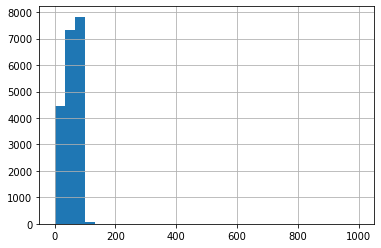

In [ ]:

text_stats = pd.DataFrame({"text": text_len})
text_stats["text"].hist(bins=30, range=(0, 1000))
plt.show()

In [ ]:
max_text_len = 50
max_title_len = 7

In [ ]:
udf['title'] = udf["title"].apply(lambda x : 'sostok ' + x + ' eostok')

In [ ]:
x_tr, x_tst, y_tr, y_tst = train_test_split(udf["cleaned_text"], udf["title"], test_size=0.2, random_state=0)

In [ ]:
token = Tokenizer(num_words=5000)
token.fit_on_texts(x_tr)

x_tr_seq = token.texts_to_sequences(x_tr)
x_tst_seq = token.texts_to_sequences(x_tst)

x_voc = token.num_words + 1

x_tr = pad_sequences(x_tr_seq, maxlen=max_text_len, padding='post', truncating='post')
x_tst = pad_sequences(x_tst_seq, maxlen=max_text_len, padding='post', truncating='post')

In [ ]:
y_tok = Tokenizer(num_words=3000)
y_tok.fit_on_texts(y_tr)

y_tr_seq = y_tok.texts_to_sequences(y_tr)
y_tst_seq = y_tok.texts_to_sequences(y_tst)


In [ ]:
index = []

for i in range(len(y_tr_seq)):
  if(len(y_tr_seq[i]) <= 3):
    index.append(i)
y_tr_seq = np.delete(y_tr_seq, index, axis=0)
x_tr = np.delete(x_tr, index, axis=0)

index = []

for i in range(len(y_tst_seq)):
  if(len(y_tst_seq[i]) <= 3):
    index.append(i)
y_tst_seq = np.delete(y_tst_seq, index, axis=0)
x_tst = np.delete(x_tst, index,axis=0)

In [ ]:
y_tr = pad_sequences(y_tr_seq, maxlen=max_title_len, padding='post', truncating='post')
y_tst = pad_sequences(y_tst_seq, maxlen=max_title_len, padding='post', truncating='post')

In [ ]:
y_voc = y_tok.num_words + 1

In [ ]:
latent_dim = 150
embedding_dim = 200

enc_input = Input(shape=(max_text_len, ))
enc_emb = Embedding(x_voc, embedding_dim, trainable=True, mask_zero=True)(enc_input)
enc_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, go_backwards=True)
enc_output, state_h, state_c = enc_lstm(enc_emb)


dec_input = Input(shape=(None, ))
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True, mask_zero=True)
dec_emb = dec_emb_layer(dec_input)
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_output, dec_state_h, dec_state_c = dec_lstm(dec_emb, initial_state=[state_h, state_c])

dense_layer = TimeDistributed(Dense(latent_dim, activation='tanh'))
dense_output = dense_layer(dec_output)

output_layer  = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_output = output_layer(dense_output)

model = Model([enc_input, dec_input], decoder_output)
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 50, 200)      1000200     input_29[0][0]                   
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, None, 200)    600200      input_30[0][0]                   
___________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1, min_delta=0.0001)
mc = ModelCheckpoint('/content/drive/My Drive/ML_Data/TextSummary.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
history = model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:], 
                    epochs=50, callbacks=[es, mc], batch_size=32, validation_data=([x_tst, y_tst[:, :-1]], y_tst.reshape(y_tst.shape[0], y_tst.shape[1], 1)[:,1:]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14059 samples, validate on 3448 samples
Epoch 1/50
14059/14059 [==============================] - 63s 4ms/step - loss: 3.6915 - val_loss: 3.1852

Epoch 00001: val_loss improved from inf to 3.18516, saving model to /content/drive/My Drive/ML_Data/TextSummary.h5
Epoch 2/50
14059/14059 [==============================] - 62s 4ms/step - loss: 3.1633 - val_loss: 3.0112

Epoch 00002: val_loss improved from 3.18516 to 3.01120, saving model to /content/drive/My Drive/ML_Data/TextSummary.h5
Epoch 3/50
14059/14059 [==============================] - 62s 4ms/step - loss: 2.9775 - val_loss: 2.9184

Epoch 00003: val_loss improved from 3.01120 to 2.91842, saving model to /content/drive/My Drive/ML_Data/TextSummary.h5
Epoch 4/50
14059/14059 [==============================] - 62s 4ms/step - loss: 2.8470 - val_loss: 2.8609

Epoch 00004: val_loss improved from 2.91842 to 2.86092, saving model to /content/drive/My Drive/ML_Data/TextSummary.h5
Epoch 5/50
14059/14059 [==============================]

In [ ]:
model = load_model('/content/drive/My Drive/ML_Data/TextSummary.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


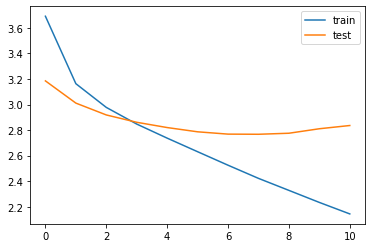

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_source_index = dict((v, k) for k, v in token.word_index.items())
reverse_target_index = dict((v, k) for k, v in y_tok.word_index.items())

In [ ]:
encoder_model = Model(inputs=enc_input, outputs=[enc_output, state_h, state_c])

decoder_state_h = Input(shape=(None, ))
decoder_state_c = Input(shape=(None, ))
deocoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

dec_emb = dec_emb_layer(dec_input)

dec_outputs, dec_h, dec_c = dec_lstm(dec_emb, initial_state=[decoder_state_h, decoder_state_c])

dec_outputs = dense_layer(dec_outputs)

decoder_output2 = output_layer(dec_outputs)

decoder_model = Model(
    [dec_input] + [deocoder_hidden_state_input, decoder_state_h, decoder_state_c],
    [decoder_output2] + [dec_h, dec_c]
)

In [ ]:
def decoder_sequence(input_seq):
  e_o, e_h, e_c = encoder_model.predict(input_seq)

  target_seq = np.zeros((1, 1))

  target_seq[0, 0] = y_tok.word_index['sostok']

  stop_condition = False

  decoded_sentence = ''

  while not stop_condition:

    output_tok, h, c = decoder_model.predict([target_seq] + [e_o, e_h, e_c])
    print(output_tok)
    sample_token_index = np.argmax(output_tok[0,-1,:])

    sampled_token = reverse_target_index[sample_token_index]

    if(sampled_token != 'eostok'):
      decoded_sentence =  decoded_sentence + sampled_token + ' '
    
    if((sampled_token == 'eostok')  or (len(decoded_sentence.split() >= max_title_len-1 ))):
      stop_condition= True
    
    target_seq = np.zeros((1, 1))

    target_seq[0, 0] = sample_token_index

    e_h, e_c = h, c

  return decoded_sentence.strip()

In [ ]:
def seq2source(input_seq):
  new_string = ''
  for i in input_seq:
    if(i!=0):
      new_string = new_string + reverse_source_index[i] + ' '
  return new_string.strip()
  

In [ ]:
source = []

for i in range(len(x_tst)):
  source.append(seq2source(x_tst[i]))

In [ ]:
y_tst = [' '.join(i.split()[1:-1])  for i in y_tst]

In [ ]:
index=[]
for i in range(len(source)):
  if(len(source[i].split()) >= 10):
    index.append(i)

In [ ]:
import random

for i in random.sample(range(0, len(x_tst)+1), 20):
  print("Actual Summary: ", y_tst[index[i]])
  print("Predicted Summary: ", decoder_sequence(x_tst[index[i]].reshape(1, max_title_len)))
  print("\n")